# Single weight behavior

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# import pystan
import scipy.stats as stats
import seaborn as sns
import tqdm
import sys
import pandas as pd
from IPython.display import display

import tensorflow as tf
from numpy import trapz
from scipy import integrate

sns.set(style="whitegrid", font_scale=2.25)
sys.path.append('../')



try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_fast.py
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    from src.vimlts_fast import VimltsLinear, ConjungateDenseViGauss

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import initializers
from functools import partial

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )
log=tf.math.log

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Tensorflow version:  2.6.2


## Data generating process
Draw samples from a mixture distribution

$y \sim MixtureCauchy(\mu_{0},\sigma, \mu_{1},\sigma)$

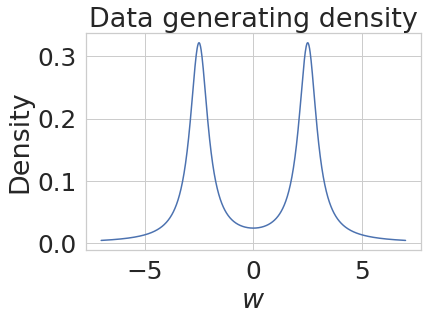

In [2]:
mu_0=2.5
mu_1=-2.5
sigma=sigma_0=sigma_1=0.5
mix=0.5

# Cauchy mixture distribution
a_bimix_cauchy = tfd.Mixture(
  cat=tfd.Categorical(probs=[mix, 1.-mix]),
  components=[
    tfd.Cauchy(loc=mu_0, scale=sigma_0),
    tfd.Cauchy(loc=mu_1, scale=sigma_1),
])

ww=np.linspace(-7.,7.,num=int(1e3))

plt.figure()
plt.plot(ww, a_bimix_cauchy.prob(ww))
plt.title(r'Data generating density')
plt.ylabel(r'Density')
plt.xlabel(r'$w$');

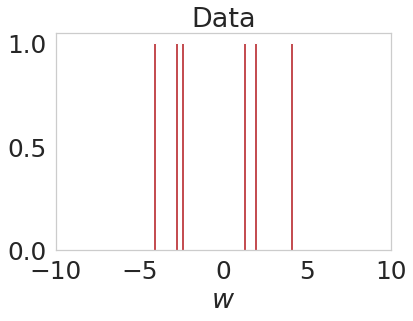

In [3]:
data_file = "01_singel_weight_data.npy"
try:
    y = np.load(data_file)
    num = len(y)
except:
    num = 6
    tf.random.set_seed(0)
    y = a_bimix_cauchy.sample(sample_shape=num)

    y=np.array(y).reshape([-1])
    np.save(data_file, y)

plt.hist(y, color='r',bins=50)
plt.xlim([-10,10])
plt.grid()
plt.title(r'Data')
plt.xlabel(r'$w$');

## Ground truth

In [4]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 50, zorder=1, density=True)
    sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [11]:
stan_code = """
data{
  int<lower=0> N;
  real<lower=0> sigma;
  vector[N] y;
}
parameters{
  real w;
}
model{
  y ~ cauchy(w, sigma);
  w ~ normal(0, 1);
}
"""

mcmc_model=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3e6c130a5f8167199a3e917cb6ec796 NOW.


In [12]:
mcmc_data = {'N': num,
        'sigma': sigma,
        'y': y}
mcmc_fit=mcmc_model.sampling(data=mcmc_data,iter=8000,chains=8)

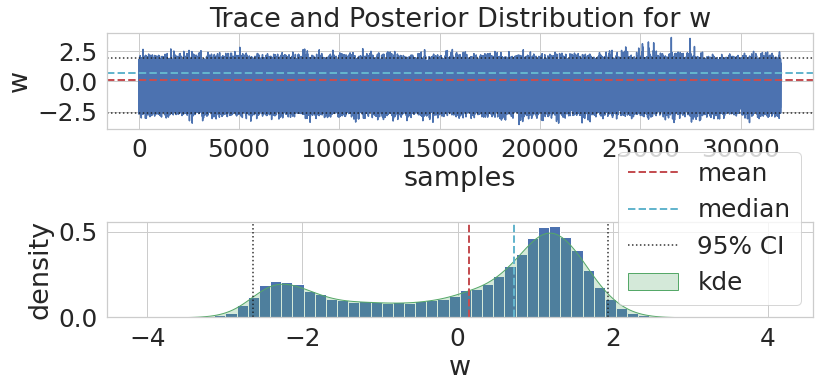

In [13]:
plt.figure(figsize=(12,6))
plot_trace(mcmc_fit.extract()['w'],"w")

In [14]:
print(mcmc_fit.stansummary())

Inference for Stan model: anon_model_b3e6c130a5f8167199a3e917cb6ec796.
8 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=32000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w      0.15    0.04   1.44  -2.63  -1.08   0.72   1.26   1.94   1641   1.01
lp__ -19.26    0.01   0.72 -20.44 -19.78 -19.27  -18.6  -18.4   4279    1.0

Samples were drawn using NUTS at Tue Nov 30 18:24:10 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Comparison with kde

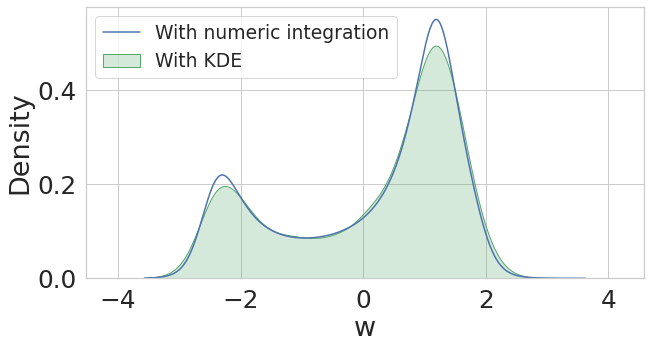

In [147]:
plt.figure(figsize=(10,5))
log_mcmc_p_w_D = mcmc_fit.to_dataframe()['lp__']
w_mcmc = mcmc_fit.to_dataframe()['w']
sort = np.argsort(w_mcmc)
# proportional
log_mcmc_p_w_D = log_mcmc_p_w_D[sort]
w_mcmc = w_mcmc[sort]
log_mcmc_p_D = np.log(np.trapz(np.exp(log_mcmc_p_w_D), w_mcmc))
plt.plot(w_mcmc, np.exp(log_mcmc_p_w_D - log_mcmc_p_D), label="With numeric integration")
sns.kdeplot(w_mcmc, color='g',zorder=2, shade=True, label=r'With KDE')
plt.legend(fontsize='x-small')
# sns.kdeplot(w_mcmc, color='r',zorder=2, shade=True, label=r'kde', bw_method='silverman', bw_adjust=0.5)



## MFVI

### Create a model

In [5]:
# Prior
prior_dist=tfd.Normal(loc=0.,scale=1.)

ytensor = y.reshape([len(y),1])

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

models = {}
theta_start = -5
theta_stop = 5
# Number of samples psi to approximate the expected value
num_samples=10000
Ms = [1,3,10,30,100,]
for M in Ms:
    # init params
    kernel_initializers=dict(kernel_init_alpha_w = initializers.Constant(1.),
                             kernel_init_beta_w = initializers.Constant(0.),
                             kernel_init_alpha_z = initializers.Constant(1.),
                             kernel_init_beta_z = initializers.Constant(0.),
                             kernel_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])
    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=lambda x: x,
                         **kernel_initializers,
                         num_samples=num_samples,
                         prior_dist=prior_dist,
                         input_shape=(1,))
    model = tf.keras.Sequential([layer], name=f"VIMLTS-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"TM-VI, M={M}"] = model
model.summary()

class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        # kl = [layer.losses[0] for layer in self.model.layers]
        # # logs['kl'] = tf.reduce_sum(kl)
        # logs['kl'] = kl

def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    if epoch > epochs:
        return lr_stop
    else:
        return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_nll(y_obs, y_pred, scale=sigma):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    # dist = tfp.distributions.Normal(loc=y_pred, scale=scale)
    dist = tfd.Cauchy(loc=y_pred, scale=scale)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "VIMLTS-degree100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_4 (VimltsLinea (10000, None, 1)          105       
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [6]:
tf.random.set_seed(2)
vi_gauss_l = ConjungateDenseViGauss(1,
                                    activation=lambda x: x,
                                    num_samples=num_samples,
                                    kernel_init_mu_w = initializers.Constant(0.),
                                    kernel_init_rhosigma_w = initializers.Constant(softplus_inv(2.5)),
                                    prior_dist=prior_dist)
vi_gauss = tf.keras.Sequential([vi_gauss_l], name="Gauss-VI")
vi_gauss.build(input_shape=(None,1))
vi_gauss.summary()
models["Gauss-VI"] = vi_gauss

Model: "Gauss-VI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conjungate_dense_vi_gauss (C (10000, None, 1)          2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,[[2.5]])


Text(0.5, 1.0, 'Posterior initial distribution')

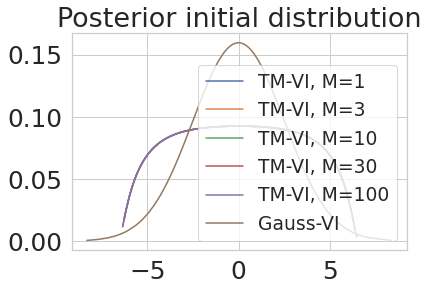

In [7]:
for name, model in models.items():
    layer = model.layers[0]
    w, log_qw = layer.sample(num=1000)
    w = w.numpy().squeeze()
    sort = np.argsort(w)
    w = w[sort]
    qw = np.exp(log_qw.numpy().squeeze()[sort])
    plt.plot(w, qw, label=name, linewidth=1.5)
plt.legend(fontsize='x-small')
plt.title("Posterior initial distribution")

### train the models

In [8]:
# Learning rate
epochs = 1000
epoch_lr_end = epochs // 2
for name, model in models.items():
    print(f"Start experiment with model {name}")
    # lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=lr_start, lr_stop=lr_end, epochs=epoch_lr_end))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss=sample_nll, run_eagerly=False)
    model.fit(tf.ones(ytensor.shape), ytensor, epochs=epochs, verbose=False, callbacks=[LogKL()])

Start experiment with model TM-VI, M=1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Start experiment with model TM-VI, M=3
Start experiment with model TM-VI, M=10
Start experiment with model TM-VI, M=30
Start experiment with model TM-VI, M=100
Start experiment with model Gauss-VI


In [121]:
from scipy.stats import cauchy, norm
# Compute posterior from samples
def posterior_unnormalized(samples, data, prior_dist=tfd.Normal(loc=0, scale=1.)):
    assert len(samples.shape) == 1, "Expected samples to be one dimensional"
    log_liks = np.sum(cauchy.logpdf(data.reshape(1,-1), loc=samples.reshape(-1,1), scale=sigma), axis=1)
    priors = prior_dist.log_prob(samples).numpy()
    post_un = log_liks + priors
    sort = np.argsort(samples)
    samples_s = samples[sort]
    post_un_s = post_un[sort]
    return post_un_s

def posterior_unnormalized_single(xi, data=ytensor, prior_dist=tfd.Normal(loc=0, scale=1.)):
    log_liks = np.sum(cauchy.logpdf(data.reshape(1,-1), loc=xi, scale=sigma), axis=1)
    priors = prior_dist.log_prob(xi).numpy()
    post_un = log_liks + priors
    return np.exp(post_un)

In [125]:
# compute log(p(D))
x =np.linspace(-10,10, 1000000)
log_ps = posterior_unnormalized(x, ytensor)
log_p_D = np.log(np.trapz(np.exp(log_ps),x))
print("log_p_D with trapz: ", log_p_D)
A, e = integrate.quad(posterior_unnormalized_single, -np.inf, np.inf, epsabs=1e-40)
log_p_D = np.log(A)
print(f"log_p_D with quad: {log_p_D}, log(error):{np.log(e)}")

log_p_D with trapz:  -21.430685727904805
log_p_D with quad: -21.430685728483695, log(error):-38.2433813854188


<ipython-input-125-f0ea9a01d3e6>:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  A, e = integrate.quad(posterior_unnormalized_single, -np.inf, np.inf, epsabs=1e-40)


In [143]:
w_mcmc.to_numpy()

array([-3.567768  , -3.45538349, -3.45468723, ...,  3.25645634,
        3.54529332,  3.62505434])

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.13101545]], dtype=float32)>,[[1.1703402]])


,"$KL(q(\xi), p(\xi|D)$"
Gauss-VI,0.386345
"TM-VI, M=1",0.126330
"TM-VI, M=3",0.118449
"TM-VI, M=10",0.020762
"TM-VI, M=30",0.003487
"TM-VI, M=100",0.000411
MCMC,0.000071


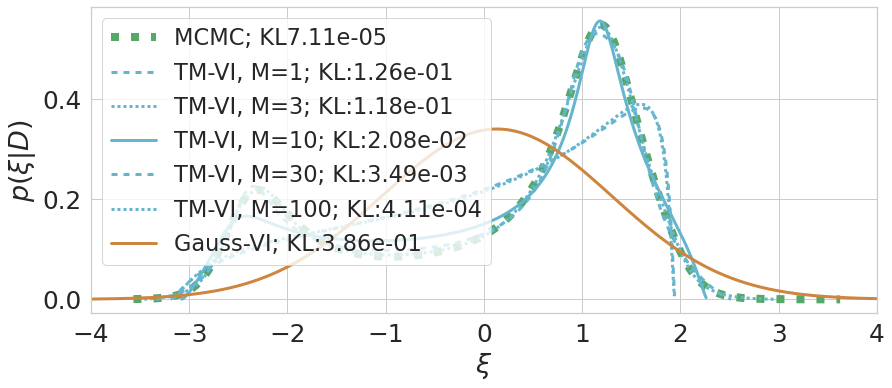

In [149]:
plt.figure(figsize=(13,6))
log_p_w_D_unnorm = posterior_unnormalized(w_mcmc.to_numpy(), ytensor, prior_dist=prior_dist)
kl_unnorm = np.mean(log_mcmc_p_w_D - log_mcmc_p_D - log_p_w_D_unnorm)
kl = log_p_D + kl_unnorm
Kls = dict(MCMC=kl)
plt.plot(w_mcmc, np.exp(log_mcmc_p_w_D - log_mcmc_p_D), label=f"MCMC; KL{kl:.2e}", linewidth=8., color='g', linestyle=(0, (1, 1.5)))
linestyles = [(0, (2, 2)), (0, (1, 1)), '-']
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    w, log_qw = layer.sample(num=100000)
    w = w.numpy().squeeze()
    sort = np.argsort(w)
    w = w[sort]
    log_qw = log_qw.numpy().squeeze()[sort]
    # compute KL
    log_p_w_D_unnorm = posterior_unnormalized(w, ytensor, prior_dist=prior_dist)
    kl_unnorm = np.mean(log_qw - log_p_w_D_unnorm)
    # 1/T \sum_{w_i \sim q(w_i}} log(q(w_i)/p(w_i|D)) => log(p(D)) + 1/T \sum_{w_i \sim q(w_i}} log(q(w_i)) - log(p(D|w_i)*p(w_i))
    Kls[name] = log_p_D + kl_unnorm
    if "TM-VI" in name:
        plt.plot(w, np.exp(log_qw), label=f"{name}; KL:{Kls[name]:.2e}", linewidth=3., color='c', linestyle=linestyles[ls%3])
        ls += 1
    else:
        plt.plot(w, np.exp(log_qw), label=f"{name}; KL:{Kls[name]:.2e}", linewidth=3., color='peru')
plt.legend(fontsize='small')
# plt.title("Posterior distribution $p(w|D)$")
plt.xlim((-4,4.))
plt.xlabel("$\\xi$")
plt.ylabel("$p(\\xi|D)$")
plt.tight_layout()
display(pd.DataFrame.from_dict(Kls, orient='index', columns=["$KL(q(\\xi), p(\\xi|D)$"]).sort_values("$KL(q(\\xi), p(\\xi|D)$", ascending=False))
plt.savefig("02_cauchy_posterior.pdf")


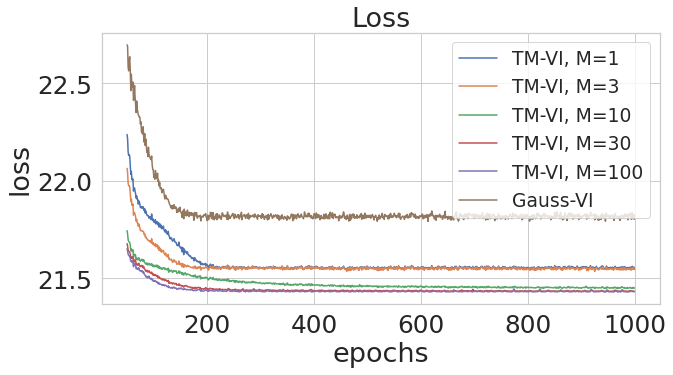

In [137]:
plt.figure(figsize=(10,5))
for m, model in models.items():
    plt.plot(model.history.history['epochs'][50:], model.history.history['loss'][50:], label=m)
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')


In [29]:
df = pd.read_csv("../src/01_single_weight_kl_eval_kl.csv")
df.pop('Unnamed: 0')
df

,seed,Gauss-VI,"TM-VI, M=1","TM-VI, M=2","TM-VI, M=3","TM-VI, M=6","TM-VI, M=10","TM-VI, M=20","TM-VI, M=30","TM-VI, M=60","TM-VI, M=100","TM-VI, M=300","TM-VI, M=200"
0,2,0.389843,0.123923,0.123853,0.117575,0.058831,0.021112,0.007254,0.003583,0.000846,0.000510,0.000116,0.000240
1,4,0.387110,0.125436,0.124907,0.117245,0.056481,0.020618,0.007157,0.003584,0.002762,0.004247,0.009918,0.008320
2,6,0.382539,0.123625,0.123850,0.117266,0.056826,0.021354,0.007188,0.003918,0.002947,0.004029,0.004075,0.003997
3,8,0.385003,0.121565,0.121333,0.119220,0.057866,0.020566,0.007892,0.004639,0.007915,0.004357,0.001172,0.001330
4,10,0.387522,0.121524,0.121234,0.116055,0.056443,0.020019,0.007330,0.004121,0.001822,0.001156,0.000642,0.000841
5,12,0.387883,0.122337,0.122019,0.117752,0.056002,0.021459,0.008210,0.005199,0.001577,0.000904,0.001112,0.000836
6,14,0.386644,0.121618,0.121307,0.118037,0.056107,0.021012,0.008406,0.003956,0.001615,0.001226,0.001109,0.001052
7,16,0.382877,0.124976,0.124619,0.117173,0.056535,0.020972,0.007198,0.003780,0.001048,0.000463,0.000226,0.000269
8,18,0.385317,0.126209,0.126131,0.118037,0.057050,0.021649,0.008603,0.004395,0.002144,0.001806,0.001752,0.001632
9,20,0.386143,0.125328,0.125111,0.118258,0.056797,0.020655,0.007136,0.003776,0.001049,0.000342,0.000294,0.000167


In [30]:
# df2 = pd.read_csv("../src/01_single_weight_kl_eval_kl26.csv")
# df2.pop('Unnamed: 0')
# df2.pop('Gauss-VI')
# df2 = pd.concat([df.set_index('seed'), df2.set_index('seed')], axis=1)
# # df2.to_csv("../src/01_single_weight_kl_eval_kl.csv")
# # df2 = df2.reset_index()
# cn_name = df2.mean().sort_values(ascending=False).index.to_list()
# df2 = df2[cn_name]
# df2.reset_index(inplace=True)
# df2.to_csv("../src/01_single_weight_kl_eval_kl.csv")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Gauss-VI'),
  Text(1, 0, 'TM-VI, M=1'),
  Text(2, 0, 'TM-VI, M=2'),
  Text(3, 0, 'TM-VI, M=3'),
  Text(4, 0, 'TM-VI, M=6'),
  Text(5, 0, 'TM-VI, M=10'),
  Text(6, 0, 'TM-VI, M=20'),
  Text(7, 0, 'TM-VI, M=30'),
  Text(8, 0, 'TM-VI, M=60'),
  Text(9, 0, 'TM-VI, M=100'),
  Text(10, 0, 'TM-VI, M=300'),
  Text(11, 0, 'TM-VI, M=200')])

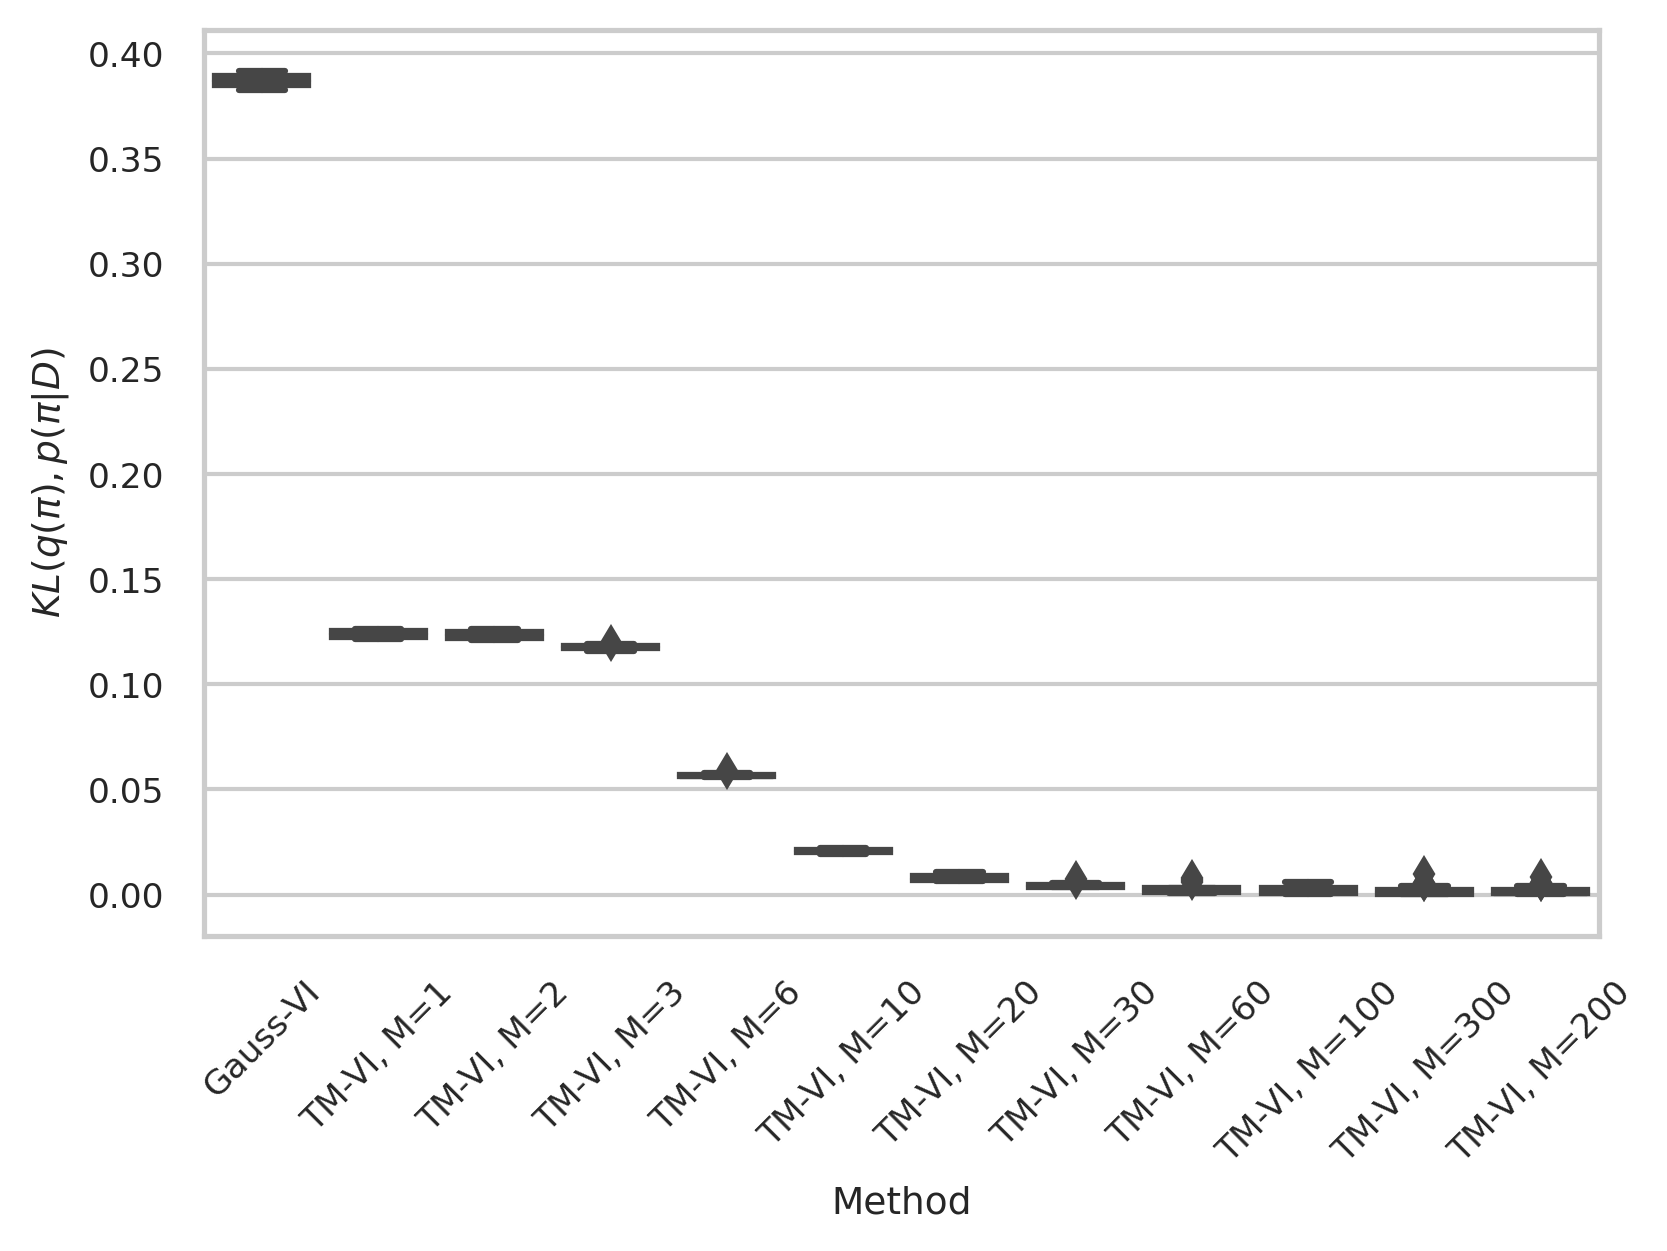

In [31]:
plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="$KL(q(\pi), p(\pi|D)$", var_name='Method')
sns.boxplot(data=dfm, y='$KL(q(\pi), p(\pi|D)$', x="Method")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Gauss-VI'),
  Text(1, 0, 'TM-VI, M=1'),
  Text(2, 0, 'TM-VI, M=2'),
  Text(3, 0, 'TM-VI, M=3'),
  Text(4, 0, 'TM-VI, M=6'),
  Text(5, 0, 'TM-VI, M=10'),
  Text(6, 0, 'TM-VI, M=20'),
  Text(7, 0, 'TM-VI, M=30'),
  Text(8, 0, 'TM-VI, M=60'),
  Text(9, 0, 'TM-VI, M=100'),
  Text(10, 0, 'TM-VI, M=300'),
  Text(11, 0, 'TM-VI, M=200')])

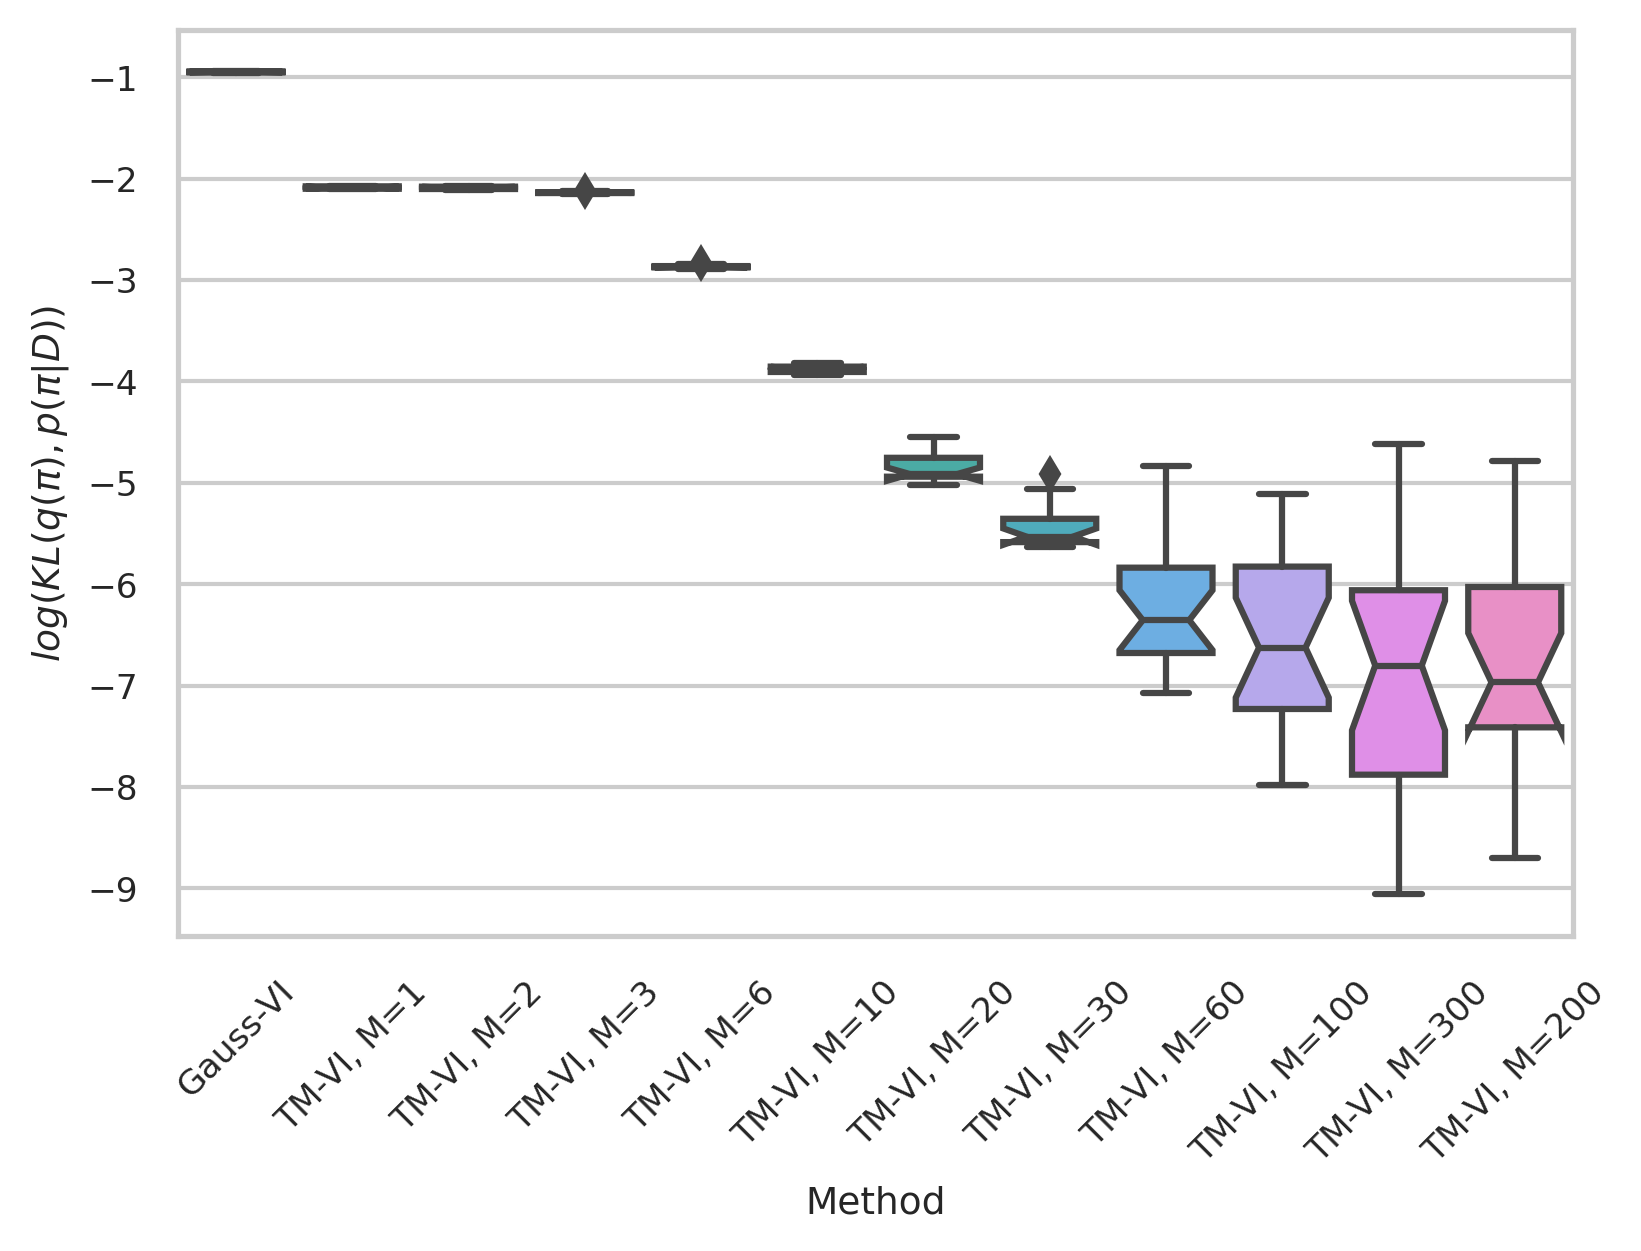

In [32]:

plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="KL", var_name='Method')
dfm['$log(KL(q(\pi), p(\pi|D))$'] = dfm['KL'].apply(np.log)
dfm.pop('KL')
sns.boxplot(data=dfm, y='$log(KL(q(\pi), p(\pi|D))$', x="Method", notch=True)
plt.xticks(rotation=45)
